# Семинар 08 - Нейросети

In [ ]:
!pip install torchvision

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
# warnings.simplefilter('ignore')
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import torch
print(torch.__version__)

D:\Anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


2.1.0+cu121


<a id="Content"></a>
# Содержание
0. [Вспомним PyTorch](#0)
1. [Подготовка данных](#1)
2. [Определим архитектуру нейросети в PyTorch](#2)
3. [Что мы можем улучшить?](#3)
   - [Нормировка](#3.1)
   - [Функции активации](#3.2)
   - [Инициализация весов](#3.3)
   - [Влияние метода оптимизации градиентного спуска](#3.4)
   - [Влияние скорости обучения](#3.5)
4. [Полезные ссылки](#4)

<a id="0"></a>
# 0. Вспомним PyTorch

Нахождение сложной производной

Найдите производную по x от функции
$$\sin\left(\tan(x)\frac{x^2}{y} + \ln(e^{-x^2 + 3}+x^3y)\right)\tan(x^2e^{x^9})$$

При этом надо пользоваться встроенным в PyTorch autograd. Численное вычисление производной может не дать нужный результат.

In [2]:
def find_x_derivative(x, y):
    x_with_grad = torch.tensor([float(x)], requires_grad=True)
    y_with_grad = torch.tensor([float(y)], requires_grad=True)

    z = torch.sin(torch.tan(x_with_grad)*(x_with_grad**2/y_with_grad) + torch.log(torch.exp(-x_with_grad**2+3) + y_with_grad*x_with_grad**3))*torch.tan(torch.exp(x_with_grad**9)*x_with_grad**2)
    z.backward()

    dz_dx = x_with_grad.grad
    return dz_dx.item(), z

In [3]:
find_x_derivative(1,21)

(-9.020709991455078, tensor([0.1239], grad_fn=<MulBackward0>))

<a id="1"></a>
# 1. Подготовка данных

### В семинаре, будем использовать набор данных `fashion_mnist`, загрузим их

In [4]:
from torchvision import datasets, transforms

In [5]:
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train = True, download=True)

In [6]:
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train = False, download = True)

In [7]:
num_classes = len(trainset.classes)

In [8]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
x_train = trainset.data
y_train = trainset.targets

x_test = testset.data
y_test = testset.targets

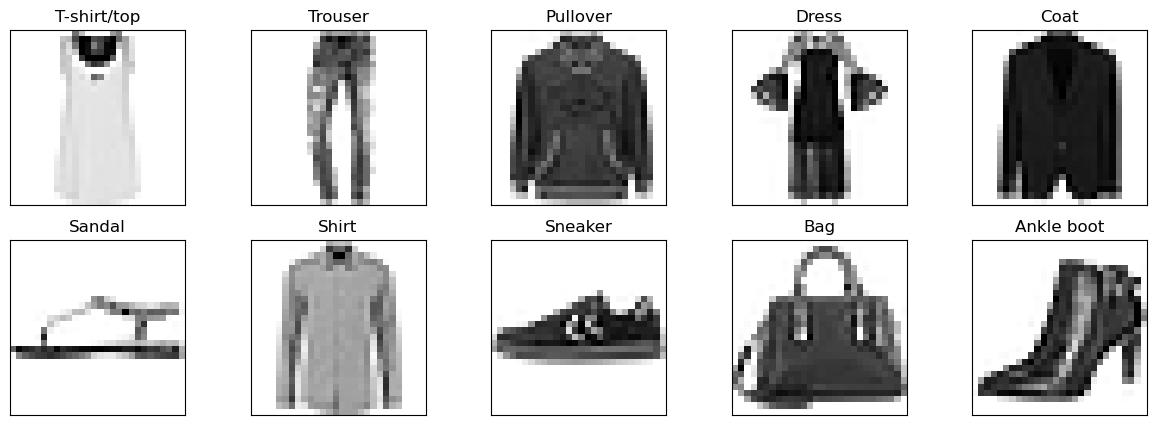

In [10]:
fig = plt.figure(figsize=(15,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(trainset.classes[i])
    plt.imshow(im, cmap='gray_r')
plt.show()

### Проведем небольшие предобработки

In [11]:
x_train_flat = x_train.flatten(start_dim=1).float()
x_test_flat = x_test.flatten(start_dim=1).float()
print(f'Была размерность: {x_train.shape}, стала: {x_train_flat.shape}')
print(f'Была размерность: {x_test.shape}, стала: {x_test_flat.shape}')

Была размерность: torch.Size([60000, 28, 28]), стала: torch.Size([60000, 784])
Была размерность: torch.Size([10000, 28, 28]), стала: torch.Size([10000, 784])


In [12]:
D_out = num_classes
D_in = x_train_flat.shape[1]

<a id="2"></a>
# 2. Определим архитектуру нейросети в PyTorch

Вариантов определения архитектуры много, рассмотрим 2 наиболее популярных варианта

In [13]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, 128),
    torch.nn.Sigmoid(),
    torch.nn.Linear(128, 10),
    torch.nn.Sigmoid(),
    torch.nn.Linear(10, D_out),
    torch.nn.Softmax(dim=1)
)

In [32]:
import torch.nn.functional as F

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(D_in, 128)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(128, 10)
        self.act2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(10, D_out)
        self.act3 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return x

model = Model()

In [33]:
model

Model(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (act1): Sigmoid()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (act2): Sigmoid()
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (act3): Softmax(dim=1)
)

In [34]:
x_train_flat.shape

torch.Size([60000, 784])

In [35]:
# Forward pass: compute predicted y by passing x to the model. Module objects
# override the __call__ operator so you can call them like functions. When
# doing so you pass a Tensor of input data to the Module and it produces
# a Tensor of output data.
y_pred = model(x_train_flat)

In [36]:
y_pred.shape

torch.Size([60000, 10])

In [37]:
loss_fn = torch.nn.CrossEntropyLoss()

In [38]:
# Compute and print loss. We pass Tensors containing the predicted and true
# values of y, and the loss function returns a Tensor containing the
# loss.
loss_old = loss_fn(y_pred, y_train)
loss_old

tensor(2.3034, grad_fn=<NllLossBackward0>)

In [39]:
acc_old = accuracy_score(y_train.numpy(), y_pred.argmax(dim=1))
acc_old

0.1

In [40]:
# Zero the gradients before running the backward pass.
model.zero_grad()

In [41]:
# Backward pass: compute gradient of the loss with respect to all the learnable
# parameters of the model. Internally, the parameters of each Module are stored
# in Tensors with requires_grad=True, so this call will compute gradients for
# all learnable parameters in the model.
loss_old.backward()

In [42]:
learning_rate = 1e-2

**Задание 0:** Обновите веса, используя градиентный спуск. 

*Hint:* Каждый параметр - это тензор из PyTorch, так что градиенты можно получить так же, как мы это делали в начале семинара. Параметры для обновления хранятся в model.parameters()

In [43]:
# Update the weights using gradient descent. Each parameter is a Tensor, so
# we can access its gradients like we did before.
with torch.no_grad():
    for parameter in model.parameters():
        parameter -= learning_rate * parameter.grad

In [44]:
y_pred = model(x_train_flat.float())
loss_new = loss_fn(y_pred, y_train)
step = loss_new.item()-loss_old.item()

acc_new = accuracy_score(y_train, y_pred.argmax(dim=1))

print(f'Лосс: {loss_old.item()} -> {loss_new.item()}. Step {step} ')
print(f'Accuracy: {acc_old} -> {acc_new}')

Лосс: 2.3033647537231445 -> 2.303344964981079. Step -1.9788742065429688e-05 
Accuracy: 0.1 -> 0.1


**Задание 1:** Реализуйте обучение модели на одном батче.

In [45]:
def batch_train(model, loss_fn, learning_rate, x, y):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()

    with torch.no_grad(): 
        for param in model.parameters():
            param -= learning_rate * param.grad

    model.zero_grad()

    return(loss.item())

In [46]:
def train(model, n_epochs, batch_size, learning_rate,  X, y, X_test, y_test):
    acc_train_all = []
    loss_train_all = []
    acc_test_all = []
    loss_test_all = []

    for epoch in range(n_epochs):

        permutation = torch.randperm(X.size()[0])

        for i in tqdm(range(0,X.float().size()[0], batch_size)):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], y[indices]
            batch_train(model, loss_fn, learning_rate, batch_x, batch_y)

        y_test_pred = model(X_test)
        y_train_pred = model(X)


        acc_train = accuracy_score(y, y_train_pred.argmax(dim=1))
        loss_train = loss_fn(y_train_pred, y).detach()
        acc_test = accuracy_score(y_test, y_test_pred.argmax(dim=1))
        loss_test = loss_fn(y_test_pred, y_test).detach()

        acc_train_all = np.append(acc_train_all, acc_train)
        loss_train_all = np.append(loss_train_all, loss_train)
        acc_test_all = np.append(acc_test_all, acc_test)
        loss_test_all = np.append(loss_test_all, loss_test)


        print(f'Epoch {epoch}: \n Accuracy - train: {acc_train} | test: {acc_test} \n Loss - train: {loss_train} | test: {loss_test}')

    return(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

In [47]:
n_epochs = 10
batch_size = 1000
learning_rate = 1
model = Model()
acc_train_all, loss_train_all, acc_test_all, loss_test_all = \
          train(model, n_epochs, batch_size, learning_rate, x_train_flat, y_train, x_test_flat, y_test)


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.92it/s]


Epoch 0: 
 Accuracy - train: 0.1997 | test: 0.1995 
 Loss - train: 2.216144323348999 | test: 2.2166857719421387


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 44.51it/s]


Epoch 1: 
 Accuracy - train: 0.29506666666666664 | test: 0.2934 
 Loss - train: 2.1468052864074707 | test: 2.14788818359375


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 45.71it/s]


Epoch 2: 
 Accuracy - train: 0.38613333333333333 | test: 0.3841 
 Loss - train: 2.106844186782837 | test: 2.1084773540496826


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 46.69it/s]


Epoch 3: 
 Accuracy - train: 0.3857833333333333 | test: 0.382 
 Loss - train: 2.06917142868042 | test: 2.070736885070801


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.73it/s]


Epoch 4: 
 Accuracy - train: 0.39493333333333336 | test: 0.3922 
 Loss - train: 2.042485475540161 | test: 2.044604778289795


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 32.44it/s]


Epoch 5: 
 Accuracy - train: 0.5325666666666666 | test: 0.5275 
 Loss - train: 1.9851922988891602 | test: 1.9868369102478027


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 47.54it/s]


Epoch 6: 
 Accuracy - train: 0.5372 | test: 0.5342 
 Loss - train: 1.953107476234436 | test: 1.9552134275436401


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.30it/s]


Epoch 7: 
 Accuracy - train: 0.5793 | test: 0.5755 
 Loss - train: 1.9247756004333496 | test: 1.927567720413208


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.99it/s]


Epoch 8: 
 Accuracy - train: 0.6395333333333333 | test: 0.6336 
 Loss - train: 1.8839006423950195 | test: 1.888049602508545


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 47.97it/s]


Epoch 9: 
 Accuracy - train: 0.64025 | test: 0.6353 
 Loss - train: 1.8586381673812866 | test: 1.8631643056869507


In [48]:
def vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all):
    fig = plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)

    plt.plot(loss_train_all, label='loss')
    plt.plot(loss_test_all, label='val_loss')

    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc_train_all, label='acc')
    plt.plot(acc_test_all, label='val_acc')

    plt.legend()
    plt.show()

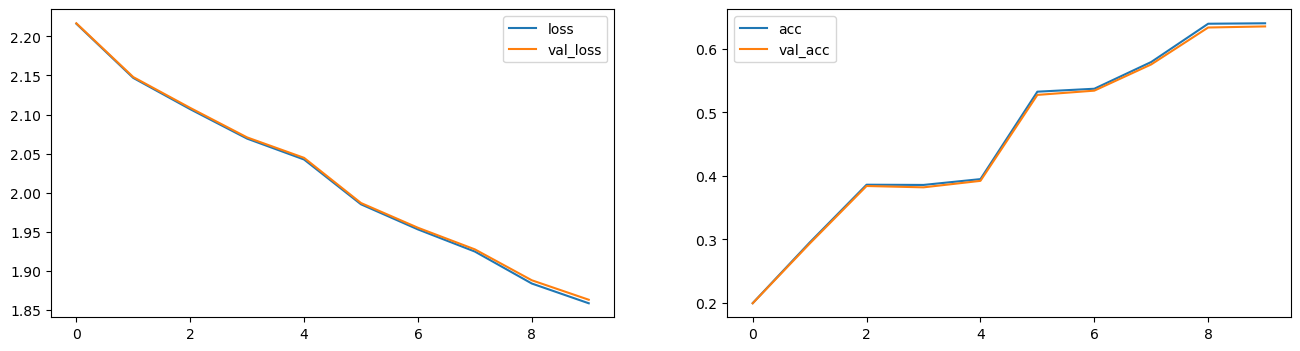

In [49]:
vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

<a id="3"></a>
# 3. Что мы можем улучшить?
- Отнормировать признаки
- Задать правила инициации весов
- Выбрать функцию активации
- Настроить скорость обучения

<a id="3.1"></a>
## 3.1. Нормировка
![picture](img/normalize.png)

![img](img/batch_norm.png)

In [50]:
import torch.nn.functional as F

class ModelNorm(torch.nn.Module):
    def __init__(self):
        super(ModelNorm, self).__init__()
        self.act1 = torch.nn.Sigmoid()
        self.fc1 = torch.nn.Linear(D_in, 128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.fc2 = torch.nn.Linear(128, 10)
        self.bn2 = torch.nn.BatchNorm1d(10)
        self.fc3 = torch.nn.Linear(10, D_out)
        self.act2 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act1(x)
        x = self.fc3(x)
        x = self.act2(x)
        return x

model_norm = ModelNorm()

In [51]:
mean = x_train_flat.mean()
std = x_train_flat.std()

x_train_norm = (x_train_flat - mean) / std
x_test_norm = (x_test_flat - mean) / std

In [53]:
x_train_norm.max(), x_train_norm.min()

(tensor(2.0224), tensor(-0.8103))

In [54]:
n_epochs = 10
batch_size = 1000
learning_rate = 1
acc_train_all, loss_train_all, acc_test_all, loss_test_all = train(model_norm, n_epochs, batch_size, learning_rate,
                                                                   x_train_norm, y_train, x_test_norm, y_test)


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 32.94it/s]


Epoch 0: 
 Accuracy - train: 0.37566666666666665 | test: 0.3749 
 Loss - train: 2.1673827171325684 | test: 2.1673531532287598


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 65.06it/s]


Epoch 1: 
 Accuracy - train: 0.47105 | test: 0.4706 
 Loss - train: 2.047064781188965 | test: 2.04723858833313


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 48.15it/s]


Epoch 2: 
 Accuracy - train: 0.47868333333333335 | test: 0.4781 
 Loss - train: 1.9821490049362183 | test: 1.9832267761230469


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 46.06it/s]


Epoch 3: 
 Accuracy - train: 0.5391166666666667 | test: 0.5374 
 Loss - train: 1.948373556137085 | test: 1.9500187635421753


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 68.28it/s]


Epoch 4: 
 Accuracy - train: 0.5853666666666667 | test: 0.5817 
 Loss - train: 1.9067095518112183 | test: 1.9090784788131714


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 70.94it/s]


Epoch 5: 
 Accuracy - train: 0.6997166666666667 | test: 0.6917 
 Loss - train: 1.8574193716049194 | test: 1.8609907627105713


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 59.19it/s]


Epoch 6: 
 Accuracy - train: 0.7141 | test: 0.7087 
 Loss - train: 1.8095455169677734 | test: 1.8141376972198486


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 53.92it/s]


Epoch 7: 
 Accuracy - train: 0.7215 | test: 0.7119 
 Loss - train: 1.7802424430847168 | test: 1.7876560688018799


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 57.51it/s]


Epoch 8: 
 Accuracy - train: 0.7240833333333333 | test: 0.7175 
 Loss - train: 1.7661927938461304 | test: 1.7730997800827026


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 67.34it/s]


Epoch 9: 
 Accuracy - train: 0.7286333333333334 | test: 0.7213 
 Loss - train: 1.75481379032135 | test: 1.7626523971557617


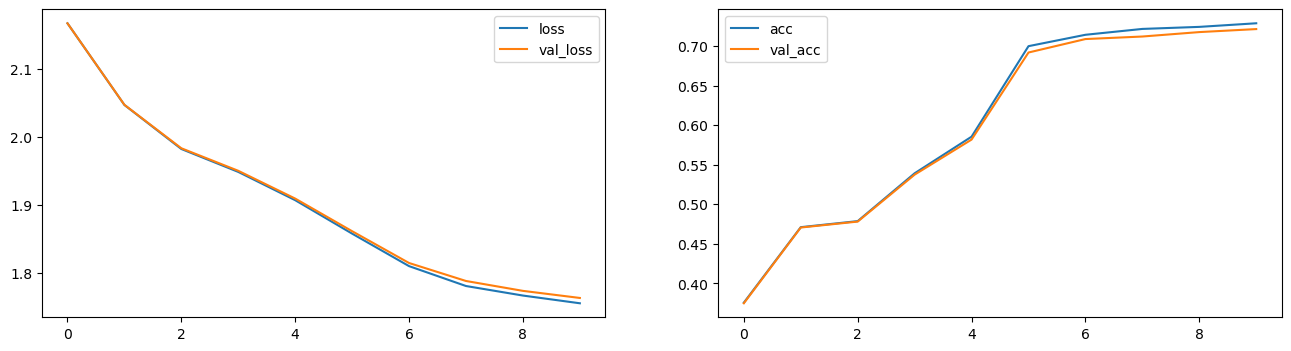

In [55]:
vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

<a id="3.2"></a>
## 3.2. Функции активации
![picture](img/activations.png)

In [56]:
class ModelReLU(torch.nn.Module):
    def __init__(self):
        super(ModelReLU, self).__init__()
        self.act1 = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(D_in, 128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.fc2 = torch.nn.Linear(128, 10)
        self.bn2 = torch.nn.BatchNorm1d(10)
        self.fc3 = torch.nn.Linear(10, D_out)
        self.act2 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act1(x)
        x = self.fc3(x)
        x = self.act2(x)
        return x

model_relu = ModelReLU()

In [57]:
n_epochs = 10
batch_size = 1000
learning_rate = 1

acc_train_all, loss_train_all, acc_test_all, loss_test_all = train(model_relu, n_epochs, batch_size, learning_rate, x_train_norm, y_train, x_test_norm, y_test)


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.49it/s]


Epoch 0: 
 Accuracy - train: 0.7732 | test: 0.7686 
 Loss - train: 1.7364230155944824 | test: 1.7411953210830688


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 61.73it/s]


Epoch 1: 
 Accuracy - train: 0.8141833333333334 | test: 0.8022 
 Loss - train: 1.659974455833435 | test: 1.6696525812149048


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 69.61it/s]


Epoch 2: 
 Accuracy - train: 0.82785 | test: 0.8166 
 Loss - train: 1.6395565271377563 | test: 1.6508289575576782


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 81.22it/s]


Epoch 3: 
 Accuracy - train: 0.82595 | test: 0.8111 
 Loss - train: 1.6405270099639893 | test: 1.6536669731140137


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 79.35it/s]


Epoch 4: 
 Accuracy - train: 0.85255 | test: 0.8339 
 Loss - train: 1.620679259300232 | test: 1.637203574180603


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 68.66it/s]


Epoch 5: 
 Accuracy - train: 0.8796 | test: 0.8582 
 Loss - train: 1.590839147567749 | test: 1.611696481704712


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 70.06it/s]


Epoch 6: 
 Accuracy - train: 0.8841666666666667 | test: 0.8617 
 Loss - train: 1.5839976072311401 | test: 1.6053545475006104


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 64.93it/s]


Epoch 7: 
 Accuracy - train: 0.8765166666666667 | test: 0.8524 
 Loss - train: 1.591023564338684 | test: 1.615029215812683


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 76.41it/s]


Epoch 8: 
 Accuracy - train: 0.8994833333333333 | test: 0.8685 
 Loss - train: 1.5675485134124756 | test: 1.595285177230835


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 78.90it/s]


Epoch 9: 
 Accuracy - train: 0.8983166666666667 | test: 0.87 
 Loss - train: 1.5679101943969727 | test: 1.5947786569595337


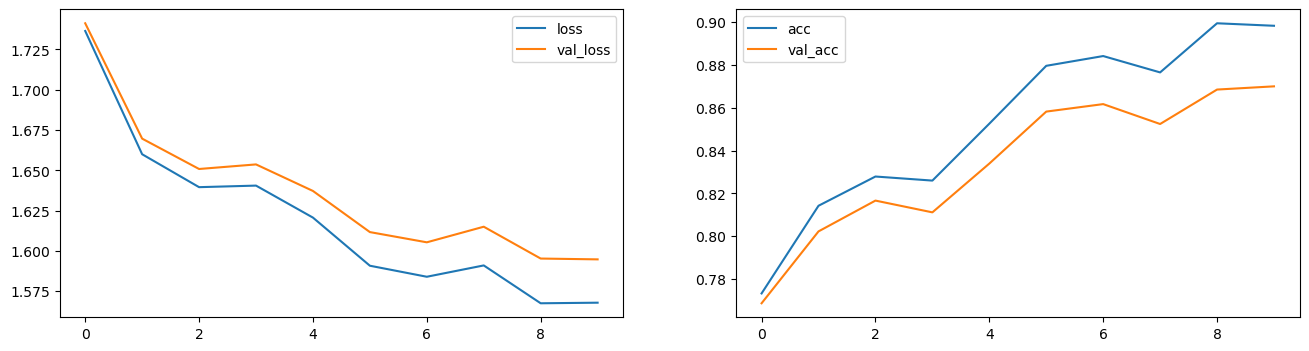

In [58]:
vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

<a id="3.3"></a>
## 3.3. Инициализация весов

__Случайно__  
$ w = a * N(0, 1)$, но тогда если $a \gg 1$, то на выходе $b\gg1$ и если $a \ll 1 $, то $b \approx 0 $  

$ D(w^T*x) = n*D(w)*D(x) $ar(x)

__Xavier__  
$a = \frac{1}{\sqrt{n}}$, где $n$ - кол-во нейронов на входе

__He__  
$a = \frac{1}{\sqrt{\frac{n}{2}}}$, где $n$ - кол-во нейронов на входе

In [62]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

Применим к модели  функцию инициации весов с помощью метода .apply()

In [63]:
model_relu = ModelReLU()

In [64]:
model_he = model_relu.apply(init_weights)

In [65]:
n_epochs = 10
batch_size = 1000
learning_rate = 1

acc_train_all, loss_train_all, acc_test_all, loss_test_all = train(model_he, n_epochs, batch_size, learning_rate,
                                                                   x_train_norm, y_train, x_test_norm, y_test)


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.50it/s]


Epoch 0: 
 Accuracy - train: 0.7797 | test: 0.7658 
 Loss - train: 1.7354803085327148 | test: 1.7471531629562378


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 46.29it/s]


Epoch 1: 
 Accuracy - train: 0.8500166666666666 | test: 0.8311 
 Loss - train: 1.6289207935333252 | test: 1.6442091464996338


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.01it/s]


Epoch 2: 
 Accuracy - train: 0.8624333333333334 | test: 0.8419 
 Loss - train: 1.6115235090255737 | test: 1.6299735307693481


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 44.12it/s]


Epoch 3: 
 Accuracy - train: 0.874 | test: 0.8496 
 Loss - train: 1.5972797870635986 | test: 1.6175329685211182


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 47.39it/s]


Epoch 4: 
 Accuracy - train: 0.8822833333333333 | test: 0.8568 
 Loss - train: 1.5874032974243164 | test: 1.6093482971191406


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.54it/s]


Epoch 5: 
 Accuracy - train: 0.8732333333333333 | test: 0.8507 
 Loss - train: 1.5946539640426636 | test: 1.6154102087020874


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.45it/s]


Epoch 6: 
 Accuracy - train: 0.8883 | test: 0.8593 
 Loss - train: 1.5784499645233154 | test: 1.6056143045425415


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 52.76it/s]


Epoch 7: 
 Accuracy - train: 0.896 | test: 0.8656 
 Loss - train: 1.571360468864441 | test: 1.5995221138000488


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 47.68it/s]


Epoch 8: 
 Accuracy - train: 0.8899333333333334 | test: 0.8611 
 Loss - train: 1.5759036540985107 | test: 1.6044392585754395


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.99it/s]


Epoch 9: 
 Accuracy - train: 0.9015 | test: 0.8691 
 Loss - train: 1.5646836757659912 | test: 1.5946650505065918


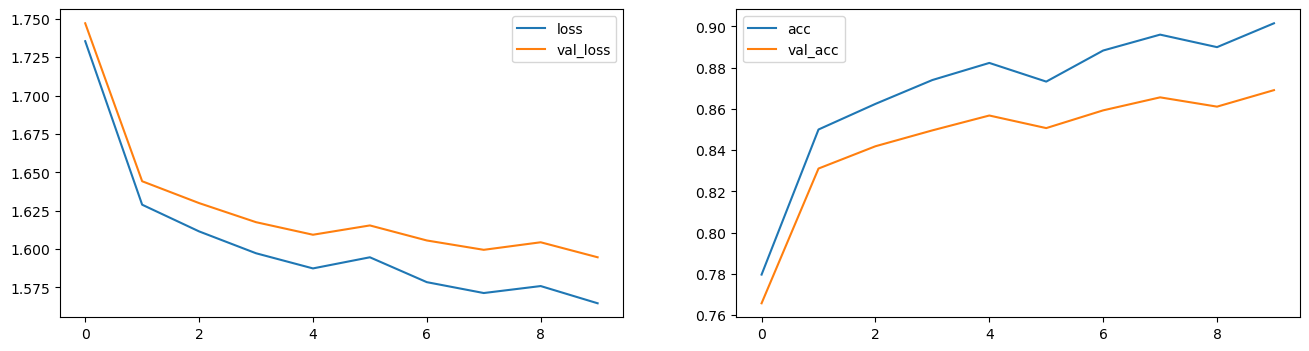

In [66]:
vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

<a id="3.4"></a>
## 3.4. Влияние метода оптимизации градиентного спуска

![picture](img/optimizers7.gif)

**Momentum**

![img](img/momentum_formula.png)

Вместо того, чтобы использовать только градиент текущего шага, мы будем накапливать импульс градиента прошлых шагов для определения направления движения.
![img](img/momentum.jpg)

В связи со стохастической природой, обновления градиента происходят "зигзагообразно", с помощью момента мы усиливаем движение вдоль основного направления. На практике коэффициент у момента инициализируется на уровне 0,5 и постепенно увеличивается до 0,9 в течение нескольких эпох.
![img](img/sgd_momentum.jpg)
  
**RMSProp** (Root Mean Square Propogation)

Покомпонентно накапливаем квадрат векторов градиентов и используем в качестве нормировки. Коэффициент $\beta$ отвечает за то, что нам важнее сохранить, предыдущие градиенты или новые.

![image](img/rmsprop.png)

**Adam** (Adaptive momentum)

Используем и накопленный импульс, и накопленный квадрат градиентов

![image](img/adam.png)новления весов для типичных признаков

### Update batch train

In [67]:
def batch_train(model, optimizer, x, y):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    return (loss.item())

### Prepare models

In [68]:
model_relu = ModelReLU()
model_he_SGD = model_relu.apply(init_weights)

In [69]:
model_relu = ModelReLU()
model_he_Momentum = model_relu.apply(init_weights)

In [70]:
model_relu = ModelReLU()
model_he_Adam = model_relu.apply(init_weights)

### Prepare optimizers

In [71]:
optimizerSGD = torch.optim.SGD(model_he_SGD.parameters(), lr=0.01, momentum=0.0)

In [72]:
optimizerMomentum = torch.optim.SGD(model_he_Momentum.parameters(), lr=0.01, momentum=0.9)

In [73]:
optimizerAdam = torch.optim.Adam(model_he_Adam.parameters(), lr=0.01)

### Train

In [74]:
n_epochs = 10
batch_size = 1000


loss_test_sgd = []
loss_test_sgd_moment = []
loss_test_adam = []

for epoch in range(n_epochs):

    permutation = torch.randperm(x_train_norm.size()[0])

    for i in tqdm(range(0,x_train_norm.float().size()[0], batch_size)):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train_norm[indices], y_train[indices]
        batch_train(model_he_SGD, optimizerSGD, batch_x, batch_y)
        batch_train(model_he_Momentum, optimizerMomentum, batch_x, batch_y)
        batch_train(model_he_Adam, optimizerAdam, batch_x, batch_y)

    y_test_pred = model_he_SGD(x_test_norm)
    loss_train = loss_fn(y_test_pred, y_test).detach().numpy()
    print(f' SGD Epoch: {epoch} loss {loss_train}')
    loss_test_sgd.append(loss_train)

    y_test_pred = model_he_Momentum(x_test_norm)
    loss_train = loss_fn(y_test_pred, y_test).detach().numpy()
    print(f' Momentum Epoch: {epoch} loss {loss_train}')
    loss_test_sgd_moment.append(loss_train)

    y_test_pred = model_he_Adam(x_test_norm)
    loss_train = loss_fn(y_test_pred, y_test).detach().numpy()
    print(f' Adam Epoch: {epoch} loss {loss_train}')
    loss_test_adam.append(loss_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.75it/s]


 SGD Epoch: 0 loss 2.2566235065460205
 Momentum Epoch: 0 loss 2.079772710800171
 Adam Epoch: 0 loss 1.6789816617965698


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 28.01it/s]


 SGD Epoch: 1 loss 2.191195487976074
 Momentum Epoch: 1 loss 1.9489392042160034
 Adam Epoch: 1 loss 1.6228690147399902


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.43it/s]


 SGD Epoch: 2 loss 2.1494593620300293
 Momentum Epoch: 2 loss 1.8762258291244507
 Adam Epoch: 2 loss 1.6125329732894897


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 31.50it/s]


 SGD Epoch: 3 loss 2.1219184398651123
 Momentum Epoch: 3 loss 1.8312804698944092
 Adam Epoch: 3 loss 1.5944569110870361


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.47it/s]


 SGD Epoch: 4 loss 2.102182149887085
 Momentum Epoch: 4 loss 1.8013172149658203
 Adam Epoch: 4 loss 1.5959798097610474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.59it/s]


 SGD Epoch: 5 loss 2.0874037742614746
 Momentum Epoch: 5 loss 1.7826497554779053
 Adam Epoch: 5 loss 1.5950936079025269


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 30.46it/s]


 SGD Epoch: 6 loss 2.075228214263916
 Momentum Epoch: 6 loss 1.7697603702545166
 Adam Epoch: 6 loss 1.588870644569397


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 31.08it/s]


 SGD Epoch: 7 loss 2.064675807952881
 Momentum Epoch: 7 loss 1.7606980800628662
 Adam Epoch: 7 loss 1.5901989936828613


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 29.57it/s]


 SGD Epoch: 8 loss 2.055309295654297
 Momentum Epoch: 8 loss 1.7533127069473267
 Adam Epoch: 8 loss 1.5880059003829956


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.10it/s]


 SGD Epoch: 9 loss 2.04687762260437
 Momentum Epoch: 9 loss 1.7467961311340332
 Adam Epoch: 9 loss 1.5872024297714233


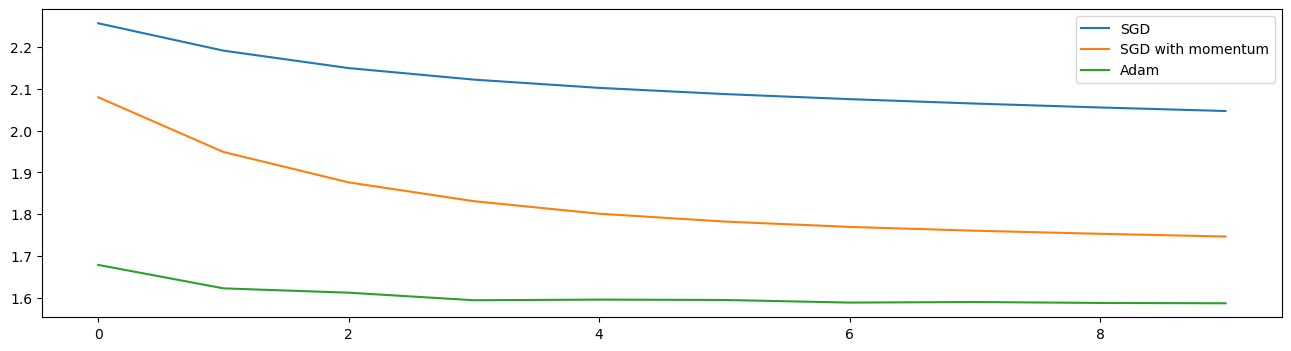

In [75]:
fig = plt.figure(figsize=(16, 4))

plt.plot(loss_test_sgd, label='SGD')
plt.plot(loss_test_sgd_moment, label='SGD with momentum')
plt.plot(loss_test_adam, label='Adam')

plt.legend()
plt.show()

<a id="3.5"></a>
## 3.5. Влияние скорости обучения
Посмотрим, как влияет параметр `learning_rate` на качество нашей модели на обучающей выборке

In [76]:
model_relu = ModelReLU()
model_he_Adam = model_relu.apply(init_weights)

In [77]:
optimizerAdam = torch.optim.Adam(model_he_Adam.parameters(), lr=0.01)

In [78]:
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.LinearLR(optimizerAdam, start_factor=1.0, end_factor=0.01, total_iters=10)

In [79]:
def train(model, optimizer, scheduler, n_epochs, batch_size,  X, y, X_test, y_test):
    acc_train_all = []
    loss_train_all = []
    acc_test_all = []
    loss_test_all = []

    for epoch in range(n_epochs):

        permutation = torch.randperm(X.size()[0])

        for i in tqdm(range(0,X.float().size()[0], batch_size)):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], y[indices]
            batch_train(model, optimizer, batch_x, batch_y)

        scheduler.step()

        y_test_pred = model(X_test)
        y_train_pred = model(X)


        acc_train = accuracy_score(y, y_train_pred.argmax(dim=1))
        loss_train = loss_fn(y_train_pred, y).detach()
        acc_test = accuracy_score(y_test, y_test_pred.argmax(dim=1))
        loss_test = loss_fn(y_test_pred, y_test).detach()

        acc_train_all = np.append(acc_train_all, acc_train)
        loss_train_all = np.append(loss_train_all, loss_train)
        acc_test_all = np.append(acc_test_all, acc_test)
        loss_test_all = np.append(loss_test_all, loss_test)


        print(f'Epoch {epoch}: \n Accuracy - train: {acc_train} | test: {acc_test} \n Loss - train: {loss_train} | test: {loss_test}')

    return(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

In [80]:
n_epochs = 10
batch_size = 1000

acc_train_all, loss_train_all, acc_test_all, loss_test_all = train(model_he_Adam, optimizerAdam, scheduler, n_epochs, batch_size,
                                                                    x_train_norm, y_train, x_test_norm, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 65.59it/s]


Epoch 0: 
 Accuracy - train: 0.8123 | test: 0.8001 
 Loss - train: 1.6688268184661865 | test: 1.6787445545196533


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 83.26it/s]


Epoch 1: 
 Accuracy - train: 0.8577333333333333 | test: 0.843 
 Loss - train: 1.6201103925704956 | test: 1.635166883468628


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 83.48it/s]


Epoch 2: 
 Accuracy - train: 0.8784 | test: 0.8536 
 Loss - train: 1.5919415950775146 | test: 1.612781047821045


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 78.88it/s]


Epoch 3: 
 Accuracy - train: 0.8913833333333333 | test: 0.8683 
 Loss - train: 1.5763916969299316 | test: 1.598333477973938


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 80.58it/s]


Epoch 4: 
 Accuracy - train: 0.8921333333333333 | test: 0.8671 
 Loss - train: 1.5740901231765747 | test: 1.5974031686782837


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 81.39it/s]


Epoch 5: 
 Accuracy - train: 0.9037 | test: 0.8744 
 Loss - train: 1.5627244710922241 | test: 1.5897635221481323


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 80.13it/s]


Epoch 6: 
 Accuracy - train: 0.9028666666666667 | test: 0.873 
 Loss - train: 1.5634841918945312 | test: 1.5917366743087769


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 66.14it/s]


Epoch 7: 
 Accuracy - train: 0.9106833333333333 | test: 0.879 
 Loss - train: 1.5553414821624756 | test: 1.585669994354248


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 73.51it/s]


Epoch 8: 
 Accuracy - train: 0.91695 | test: 0.8778 
 Loss - train: 1.549241304397583 | test: 1.5843151807785034


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 58.75it/s]


Epoch 9: 
 Accuracy - train: 0.9197666666666666 | test: 0.8807 
 Loss - train: 1.5464704036712646 | test: 1.582554578781128


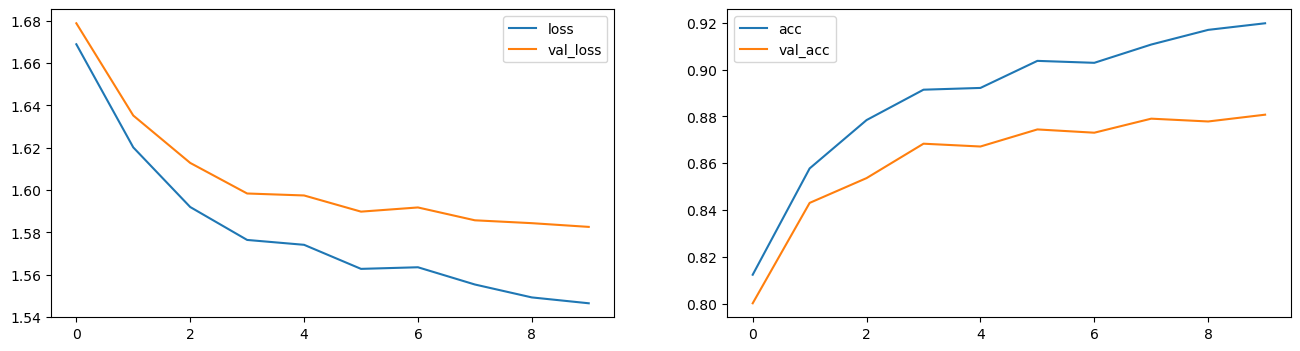

In [81]:
vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

<a id="4"></a>
# 4. Полезные ссылки
- [Курс "Deep learning на пальцах", лекция 4](https://youtu.be/tnrbx7V9RbA)
- [Статья: Методы оптимизации нейронных сетей](https://habr.com/ru/post/318970/)
- YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
- PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
- PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

Полезные ссылки 2.0:
- [Инициализация весов](https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/)
- [Почему инициализация весов нулями плохая идея?](https://habr.com/ru/articles/592711/)
- [Тонкости обучения нейронных сетей](https://education.yandex.ru/handbook/ml/article/tonkosti-obucheniya#inicializiruem-pravilno): инициализация, оптимизация, регуляризация
- [Подробнее про оптимизацию](https://education.yandex.ru/handbook/ml/article/optimizaciya-v-ml)